In [1]:
# invoke some initial libraries that we want as part of this setup
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
import pyemma.coordinates as coor

%matplotlib inline

In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False)
    frames = []
    Ca = u.select_atoms('name CA')    
    for ts in u.trajectory[::]:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
trajfile = '/home/akash/BPTI/BPTI Data/bpti_ca_1ms_dt10ns_aligned.xtc'
topfile = '/home/akash/BPTI/BPTI Data/bpti_ca.pdb'

In [4]:
coords = getCoordinates(topfile, trajfile)

/home/akash/.local/lib/python2.7/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


In [5]:
plt.style.use('ggplot')

In [6]:
print coords.shape

(412497, 3, 58)


In [8]:
import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

No handlers could be found for logger "main.IterativeMeansAlign"


In [9]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(174, 412497)


In [10]:
Nc = coords.shape[0]; # number of conformers in the simulation
dim = coords.shape[1]; # number of dimensions - usually 3
Na = coords.shape[2]; # number of atoms in the selection (from line 3)

Overall kurtosis for system: 15.9365429286
(52,)


/home/akash/.local/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/akash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/home/akash/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


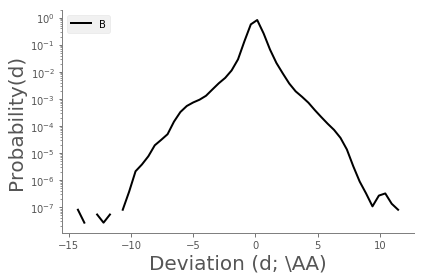

In [11]:
import scipy.stats; 

import os;
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2014/bin/x86_64-darwin/';

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']});
rc('text', usetex=False);

D = caDevsMDall.flatten(); 
[n,s] = np.histogram(D, bins=51,normed=1);
gm = np.mean(D); 
gs = np.std(D);
gK = scipy.stats.kurtosis(D,0,fisher=False);
print 'Overall kurtosis for system: ' + str(gK);
gp = np.exp(-(s-gm)**2/(2*gs*gs));
gp = gp/np.sum(gp); 

print np.shape(gp);

fig = plt.figure();
ax = plt.subplot(111, axisbg='white');   
ax.spines["top"].set_visible(False); 
ax.spines["bottom"].set_visible(True);
ax.spines["bottom"].set_color('gray');
ax.spines["right"].set_visible(False);    
ax.spines["left"].set_visible(True);
ax.spines["left"].set_color('gray');

ax.get_xaxis().tick_bottom();   
ax.get_yaxis().tick_left();

x = 0.5*(s[1:] + s[:-1]);
ax.hold(True); 
ax.semilogy(x, n, 'k-', linewidth=2.0); 
plt.legend('BPTI', loc=2, fancybox=True, framealpha=0.5);
plt.xlabel('Deviation (d; \AA)', fontsize=20);
plt.ylabel('Probability(d)', fontsize=20);
plt.tight_layout();

plt.savefig('LongTails-overall-BPTI.png', dpi=600);
plt.show();

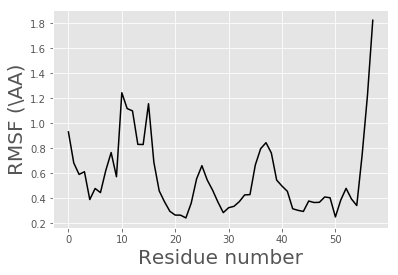

In [12]:
xx1 = np.std(caDevsMDall, 1);
rmsf_1 = np.mean(xx1.reshape((dim, Na)),0);
plt.plot(rmsf_1, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('RMSF (\AA)', fontsize=20);
plt.show();

In [13]:
mm = caDevsMDall.mean(1);
md = caDevsMDall.std(1);
cntArray = np.zeros((174,1));
for i in range(0, caDevsMDall.shape[0]):
    y = caDevsMDall[i,:]
    b = filter(lambda x: (x >= (mm[i] + 2.5*md[i]) or x <= (mm[i] - 2.5*md[i])), y); 
    cntArray[i] = len(b);

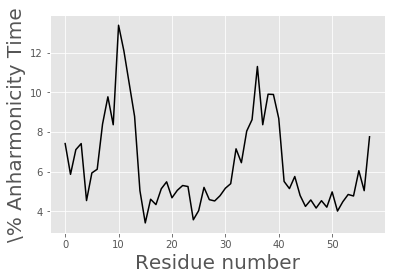

In [15]:
cntArray = cntArray.reshape((dim,Na));
bfactor = np.zeros((Na,1));
for i in range(0, Na):
    bfactor[i] = float(sum(cntArray[:,i]))*100/Nc;
plt.plot(bfactor, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('\% Anharmonicity Time', fontsize=20);
plt.show();

fi = open('/home/akash/BPTI/BPTI Data/bpti_ca.pdb', 'r');
fo = open('bpti_ca_timeSpentAnharmonic.pdb', 'w');
for line in fi.readlines():
    l = line.strip().split();
    if len(l) > 1:
        print >>fo, line[0:62], '%3.2f' %(bfactor[int(l[5])-1]);
fi.close();
fo.close();

(174, 412497)
(58, 1)


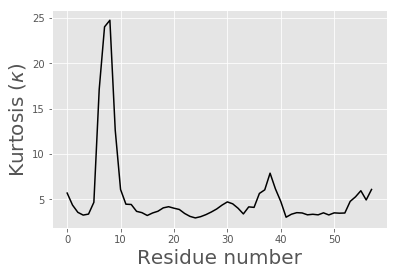

In [16]:
gK_Res = np.zeros((Na, 1)); print caDevsMDall.shape; print gK_Res.shape;
k = 0;
for i in range(0, gK_Res.shape[0]):
    kX = scipy.stats.kurtosis(caDevsMDall[i,:],0,fisher=False);
    kY = scipy.stats.kurtosis(caDevsMDall[i+1,:],0,fisher=False);
    kZ = scipy.stats.kurtosis(caDevsMDall[i+2,:],0,fisher=False);
    gK_Res[k] = np.mean([kX, kY, kZ],0);
    i = i + 3;
    k = k + 1;
plt.plot(gK_Res, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

## Kurtosis Test 

perResidue Kurtosis test is done for assessing statistical significance

Parameters:

          caDevsMDall: the C-allpha coordinates from MD simulation for BPTI trajectory
          windowsize: user specified window to choose the block size for KurtosisTest computation
          
Returns:

          gK_Zscore: Computed Z-score for the test
          gK_pvalue: 2-sided p-value for the hypothesis test
          
### Note: 
Zscore and 2-sided pvalue is saved as a text file in the program directory

In [17]:
import numpy
import scipy.stats

def perResidueKurtosisTest(caDevsMDall, windowsize):
    n = caDevsMDall.shape[1] // windowsize;
    gK_pvalue = np.zeros((caDevsMDall.shape[0],n));
    gK_Zscore = [];
    gK_pvalue = [];
    for j in range(0,n):
        for i in range(0, caDevsMDall.shape[0]):
            cc = caDevsMDall[i,(windowsize*j):(windowsize*(j+1))-1:];
            kZscore, kpvalue = scipy.stats.kurtosistest(cc,0);
            
            gK_Zscore.append(kZscore);
            gK_pvalue.append(kpvalue);
            
    gK_Zscore = numpy.asarray(gK_Zscore)
    gK_Zscore = numpy.reshape(gK_Zscore, (caDevsMDall.shape[0],n));

    gK_pvalue = numpy.asarray(gK_pvalue)
    gK_pvalue = numpy.reshape(gK_pvalue, (caDevsMDall.shape[0],n));
    return gK_Zscore, gK_pvalue;

In [18]:
Zscore, pvalue = perResidueKurtosisTest(caDevsMDall=caDevsMDall, windowsize=500);
np.savetxt('Zscore', Zscore, delimiter=' ');
np.savetxt('p-value', pvalue, delimiter=' ');